target: 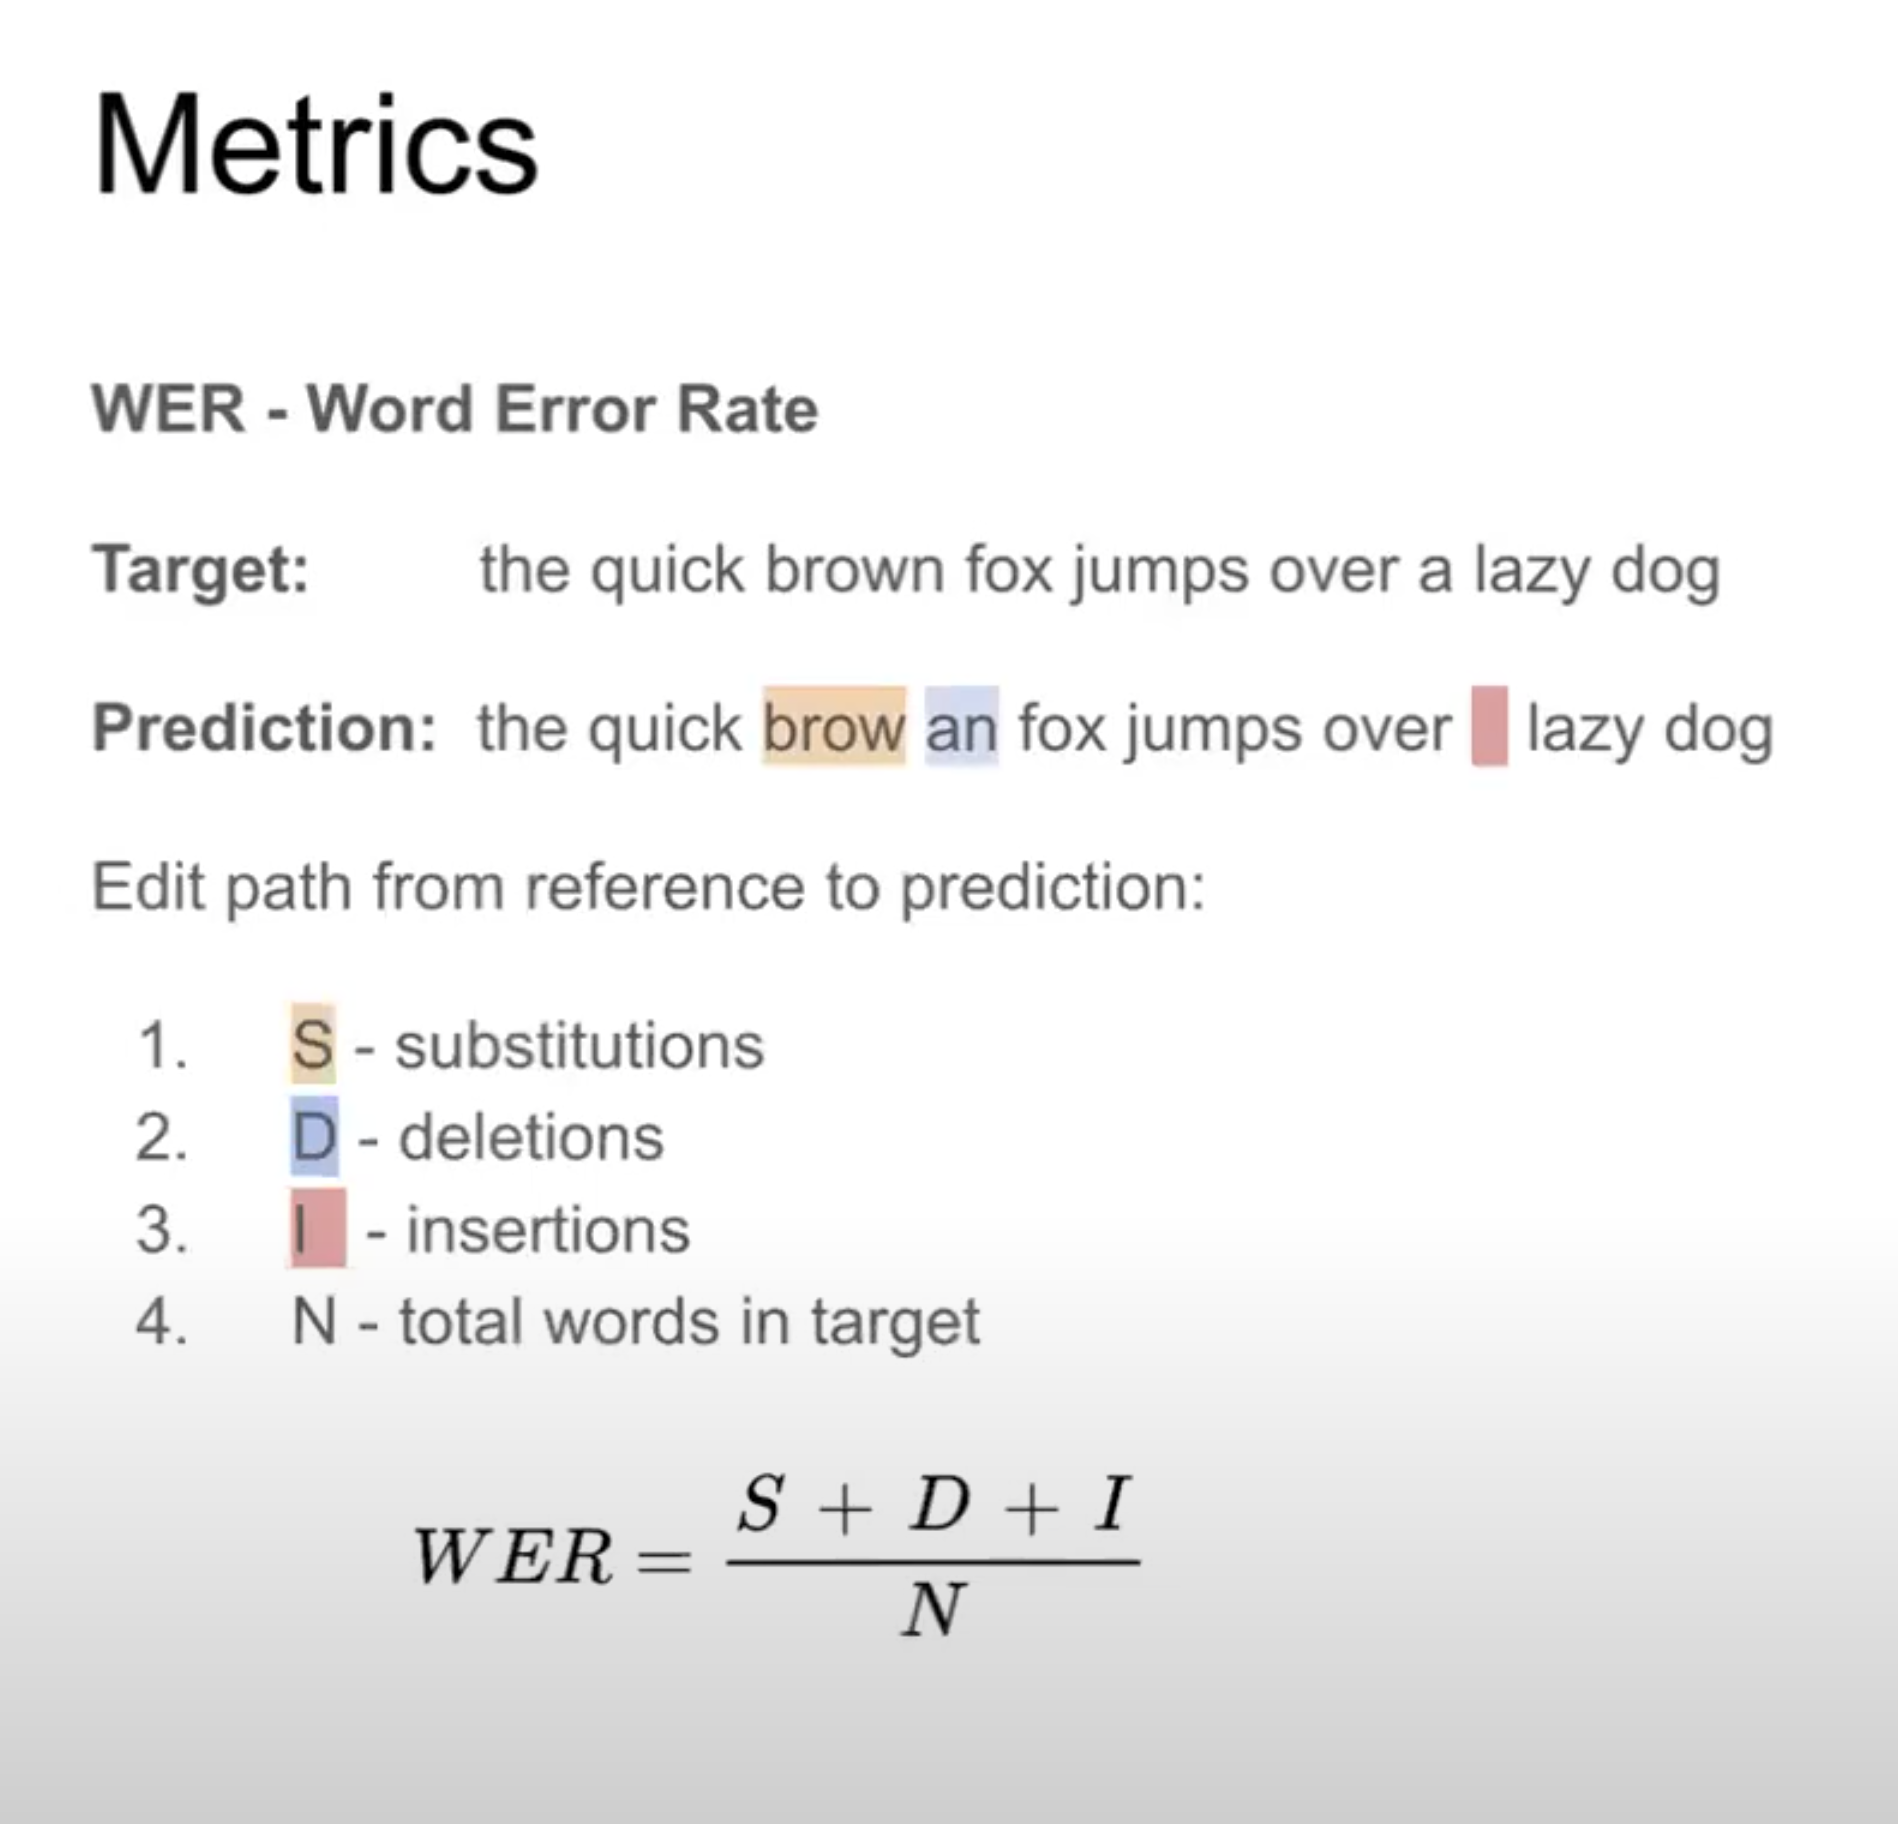

CTC properties

- no language context - outputs are independent, meaning that each letter doesn't know about others

- streamable

- produced alignment between audio and target

# Speech Augmentations

In this seminar, we will learn basic augmentations for speech.

    1) Gaussian Noise
    2) Time Stretching
    3) Pitch Shifting
    4) Volume
    5) Impulse Response
    6) Add Noise on Background
    7) SpecAug (Time/Freq masking, Cutout)

In [1]:
from IPython import display
from matplotlib import pyplot as plt

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
import torchaudio

import librosa

In [2]:
def visualize_audio(wav: torch.Tensor, sr: int = 22050):
    # Average all channels
    if wav.dim() == 2:
        # Any to mono audio convertion
        wav = wav.mean(dim=0)
    
    plt.figure(figsize=(20, 5))
    plt.plot(wav, alpha=.7, c='green')
    plt.grid()
    plt.xlabel('Time', size=20)
    plt.ylabel('Amplitude', size=20)
    plt.show()
    
    display.display(display.Audio(wav, rate=sr, normalize=False))

In [3]:
wav, sr = torchaudio.load('LJ001-0001.wav')

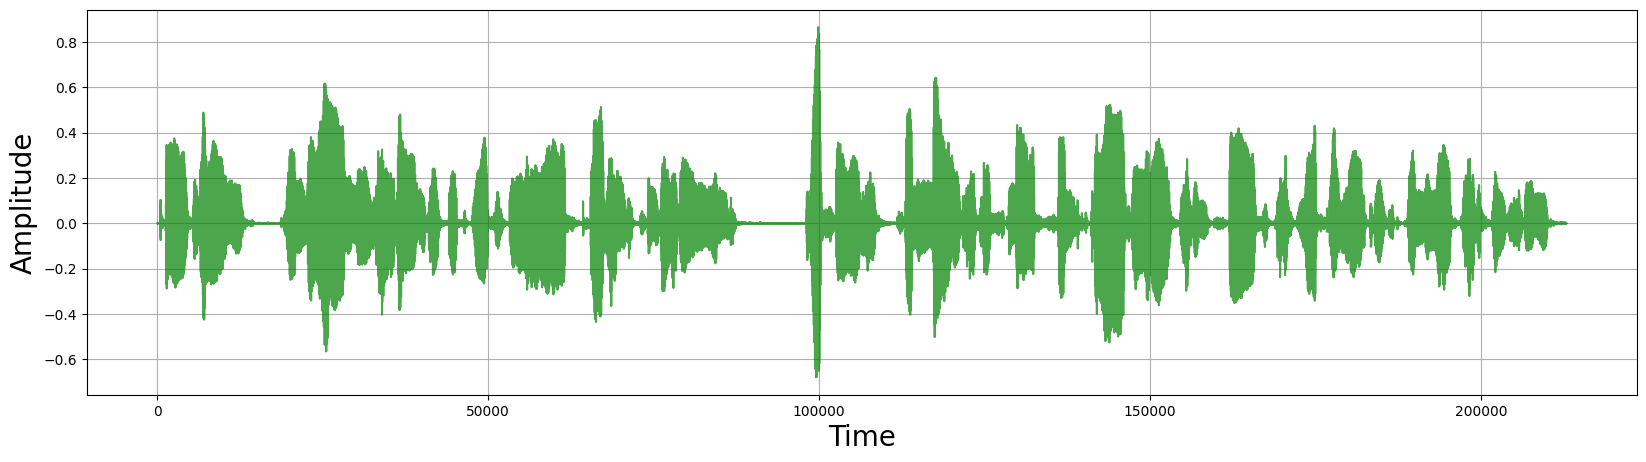

In [4]:
visualize_audio(wav)

# Gaussian Noise

In [5]:
from torch import distributions

noiser = distributions.Normal(0, 0.01)
augumented_wav_1 = wav + noiser.sample(wav.size())

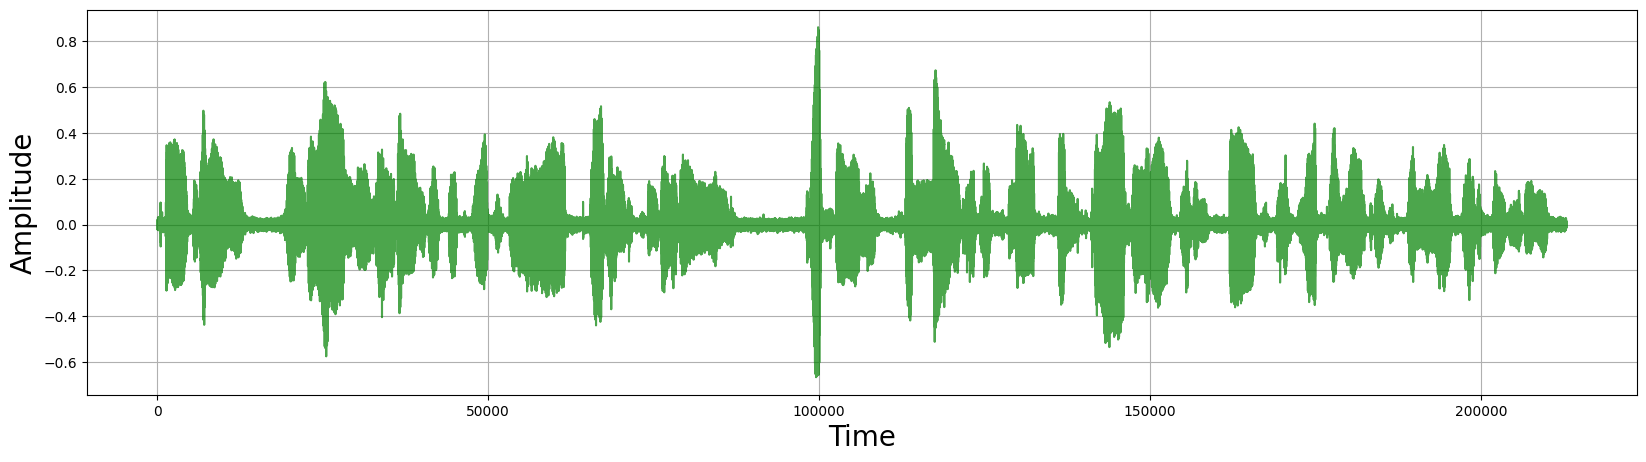

In [6]:
visualize_audio(augumented_wav_1)

# Time Stretching

Naive approach 

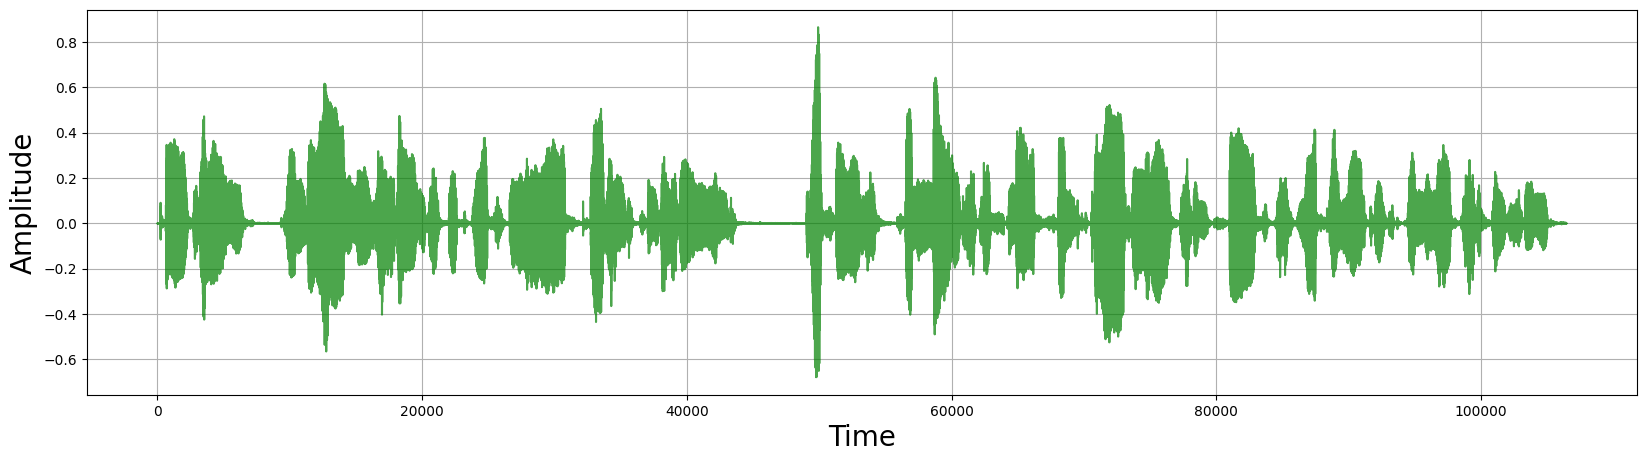

In [7]:
simple_stretch = wav[:, ::2]
visualize_audio(simple_stretch)

Advanced approach 

In [8]:
import numpy as np
def dummy_npwarn_decorator_factory():
  def npwarn_decorator(x):
    return x
  return npwarn_decorator
np._no_nep50_warning = getattr(np, '_no_nep50_warning', dummy_npwarn_decorator_factory)

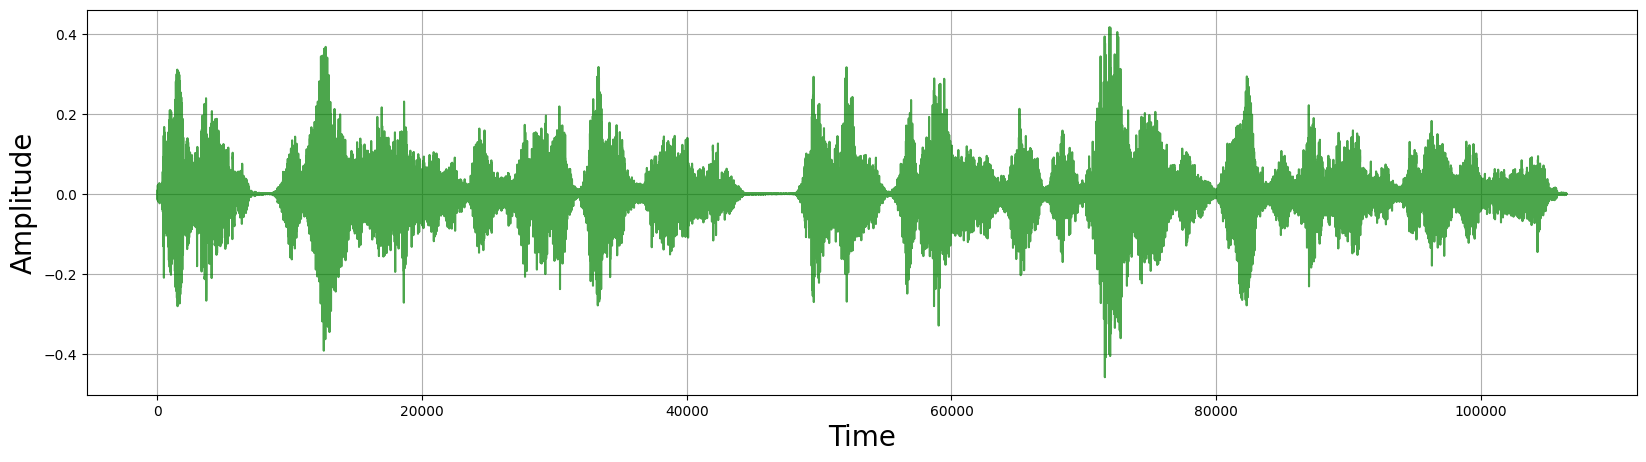

In [9]:
augumented_wav_2 = librosa.effects.time_stretch(wav.numpy().squeeze(), rate=2.0)
augumented_wav_2 = torch.from_numpy(augumented_wav_2)
visualize_audio(augumented_wav_2)

# Pitch Shifting

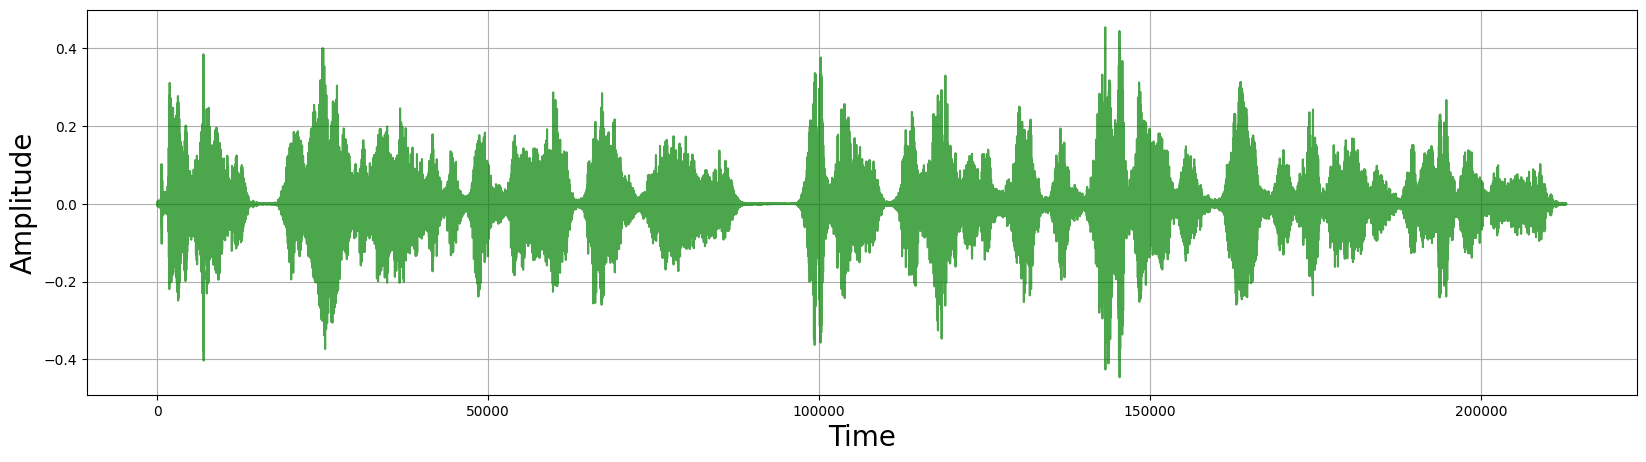

In [10]:
augumented_wav_3 = librosa.effects.pitch_shift(
    y=wav.numpy().squeeze(), sr=sr, n_steps=-5
)
augumented_wav_3 = torch.from_numpy(augumented_wav_3)

visualize_audio(augumented_wav_3)

# Volume

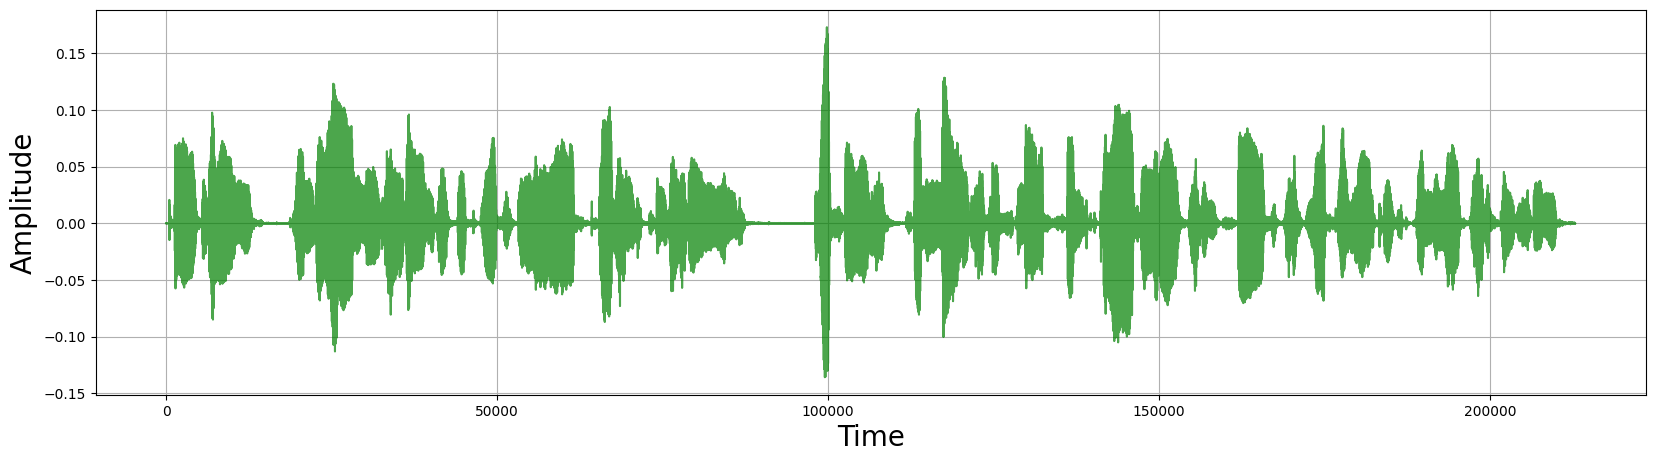

In [11]:
voler = torchaudio.transforms.Vol(gain=.2, gain_type='amplitude')
augumented_wav_4 = voler(wav)
visualize_audio(augumented_wav_4)

# Room Impulse Response

This augmentation convolves an audio signal with an impulse response. As result, we simulate new enviroment acoustic on given audio.

It may be a little bit trickly, so feel free to learn more about it:

    1) https://www.acousticalsurfaces.com/acoustic_IOI/reverberation.htm
    2) https://www.sonic-shield.com/echo-vs-reverberation
    3) https://en.wikipedia.org/wiki/Convolution_reverb
    4) https://danielpovey.com/files/2017_icassp_reverberation.pdf

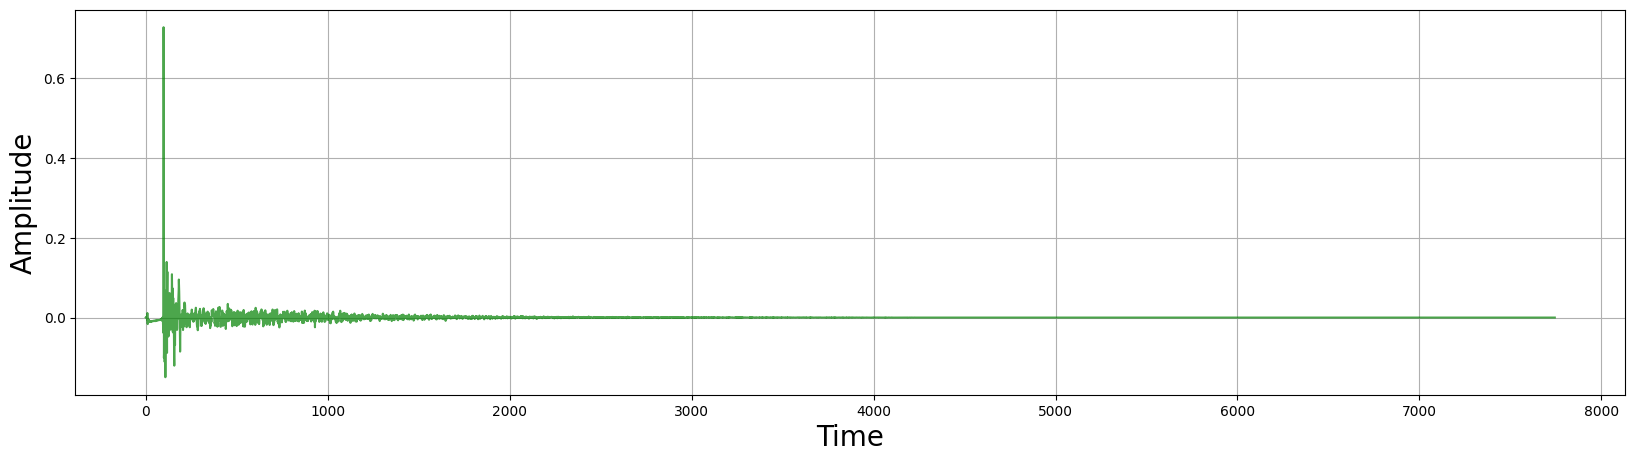

In [12]:
rir, rir_sr = torchaudio.load('h001_Bedroom_65.wav')
visualize_audio(rir, rir_sr)

In [13]:
def simulate(audio: torch.Tensor, rir: torch.Tensor):
    left_pad = right_pad = rir.shape[-1] - 1
    
    # Since torch.conv do cross-correlation (not convolution) we need to flip kernel
    flipped_rir = rir.squeeze().flip(0)

    audio = F.pad(audio, [left_pad, right_pad]).view(1, 1, -1)
    convolved_audio = torch.conv1d(audio, flipped_rir.view(1, 1, -1)) \
        .squeeze()
    
    # peak normalization
    if convolved_audio.abs().max() > 1:
        convolved_audio /= convolved_audio.abs().max()

    return convolved_audio

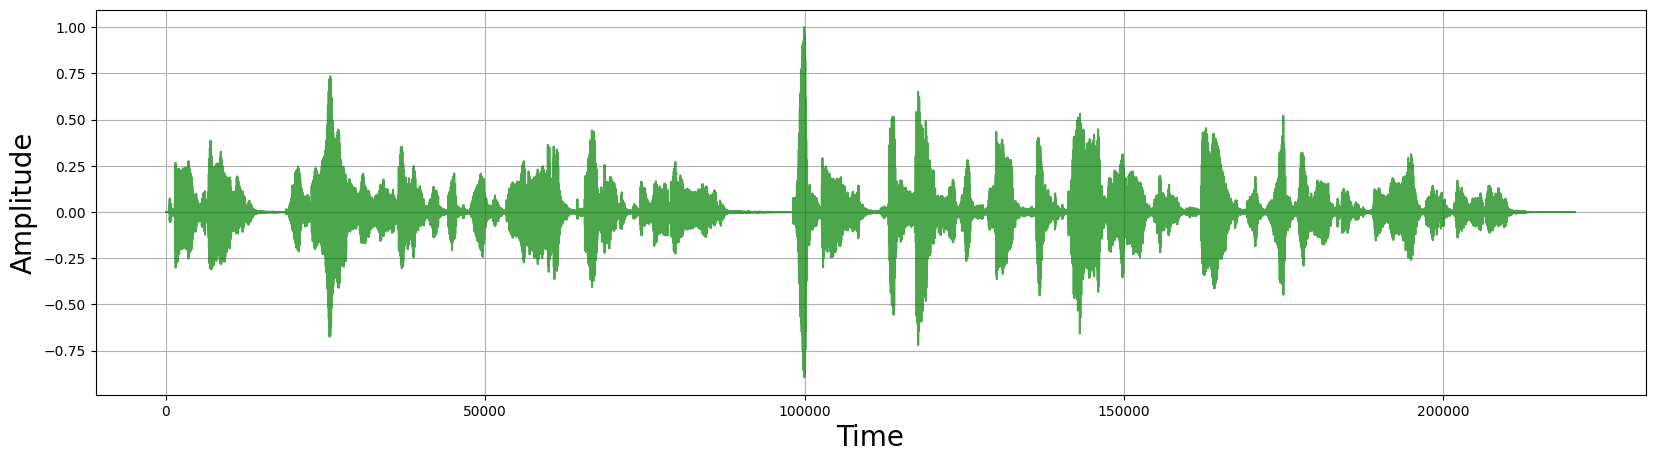

In [14]:
augumented_wav_5 = simulate(wav, rir)
visualize_audio(augumented_wav_5)

# Add noise audio on background

Let's imagine that we have a lot of samples of noises. For example, sound of street, car, talk an so on. Then we would like to add such noise to the background so that the model (for example, ASR) would be more robust to them.

There is a rule of thumb on how to properly add noise to the background:

    1) https://medium.com/analytics-vidhya/adding-noise-to-audio-clips-5d8cee24ccb8
    2) https://arxiv.org/pdf/1808.00563.pdf (3.1 chapter)

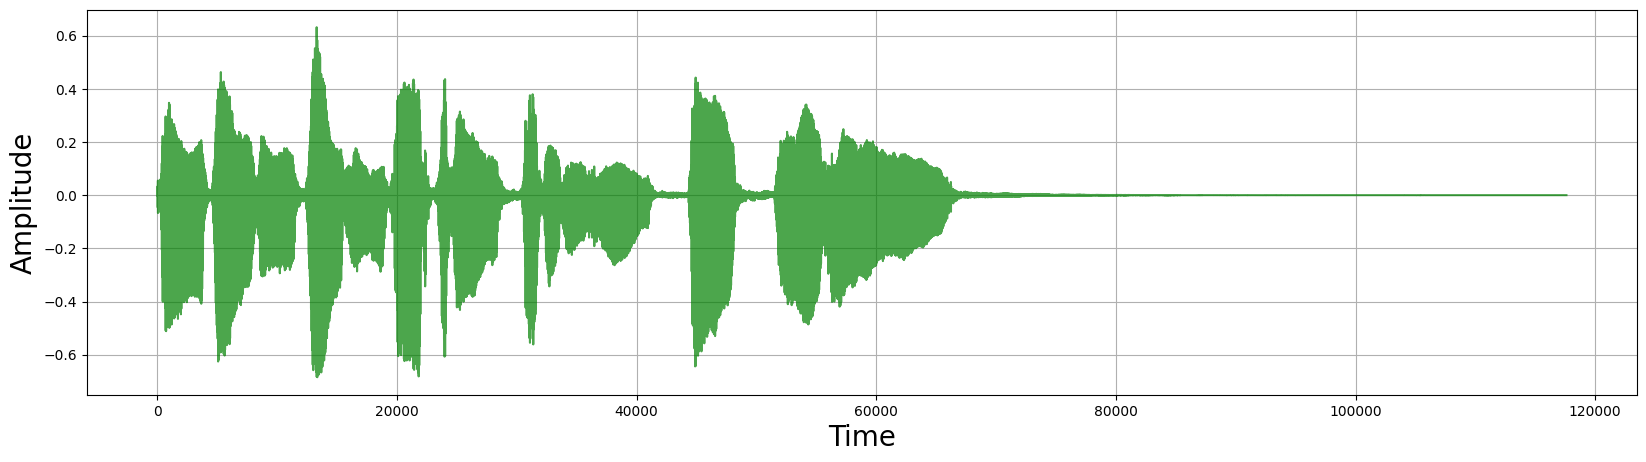

In [15]:
filename = librosa.ex('trumpet')
y, sr = librosa.load(filename)

noise = y

visualize_audio(torch.from_numpy(noise))

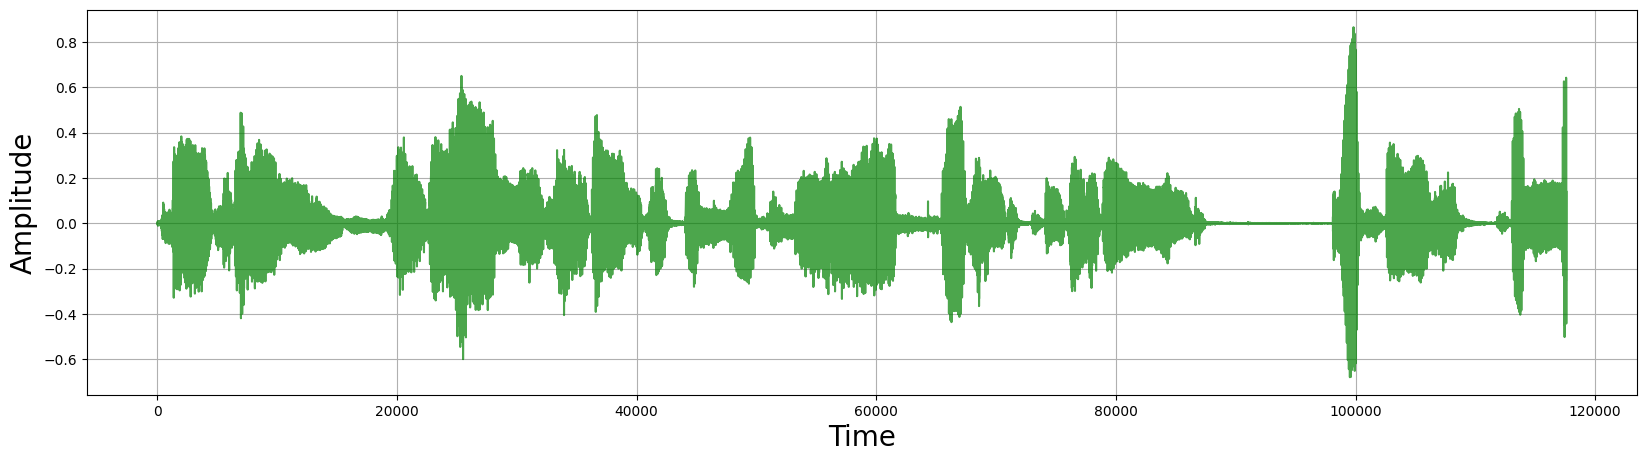

In [16]:
noize_level = torch.Tensor([20])  # [0, 40]

noize_energy = torch.norm(torch.from_numpy(noise))
audio_energy = torch.norm(wav)

alpha = (audio_energy / noize_energy) * torch.pow(10, -noize_level / 20)

clipped_wav = wav[..., :noise.shape[0]]

augumented_wav_6 = clipped_wav + alpha * torch.from_numpy(noise)

# In some cases the resulting sound may go beyond [-1, 1]
# So, clamp it :)
augumented_wav_6 = torch.clamp(augumented_wav_6, -1, 1)

visualize_audio(augumented_wav_6)

# SpecAug (Time/Freq masking, Cutout)

As we already know, main type of “features" in speech processing is (Mel)Spectrogram. From a practical point of view Spectrogram is image, so we сould apply some ideas from Computer Vision. `SpecAug` motivation come from it. 

For more details, please, visit: https://arxiv.org/pdf/1904.08779.pdf

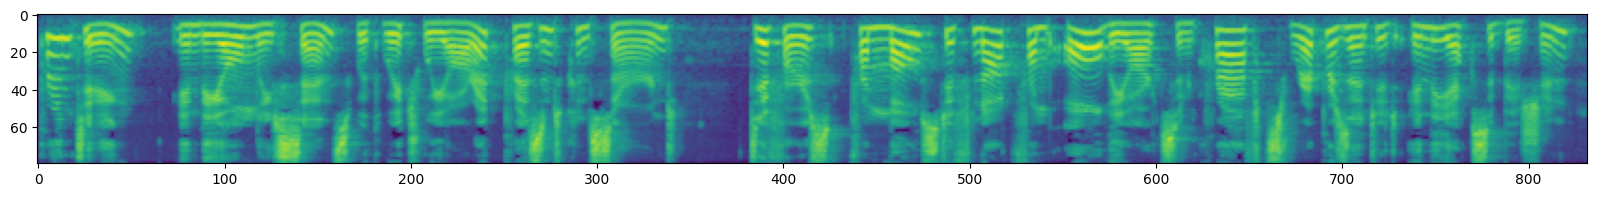

In [17]:
mel_spectrogramer = torchaudio.transforms.MelSpectrogram(
    sample_rate=22050,
    n_fft=1024,
    win_length=1024,
    hop_length=256,
    n_mels=80,
)

mel_spectrogram = mel_spectrogramer(wav)
log_mel_spectrogram = torch.log(mel_spectrogram).squeeze()
plt.figure(figsize=(20, 5))
plt.imshow(log_mel_spectrogram)
plt.show()

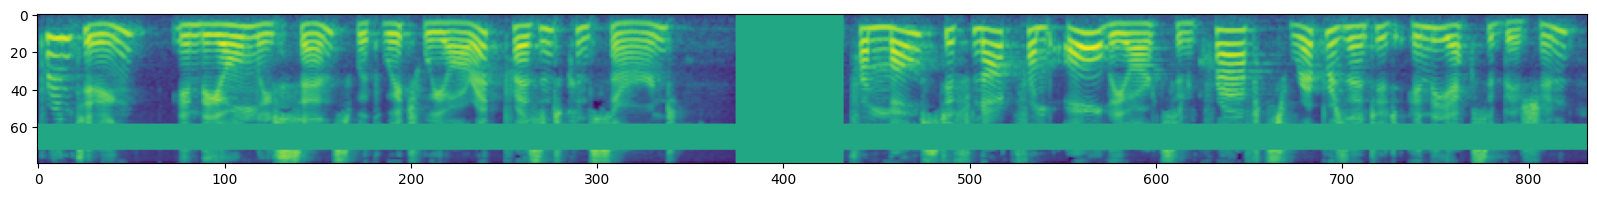

In [18]:
specaug = nn.Sequential(
    torchaudio.transforms.FrequencyMasking(20),
    torchaudio.transforms.TimeMasking(100),
)

augumented_log_mel_spectrogram = specaug(log_mel_spectrogram)

plt.figure(figsize=(20, 5))
plt.imshow(augumented_log_mel_spectrogram)
plt.show()

# STT Metrics, CTC

In [19]:
import pickle
import torch


# Load precomputed CTC output
with open('mystery_records.pickle', 'rb') as f:
    batch = pickle.load(f)

# log probabilities of softmax layers [batch_size, T, vocab_size]
log_probs = batch["log_probs"]

# Dictionary with index to character mapping
ind2char = batch["ind2char"]

# Index of special EMPTY token
EMPTY_TOK = '^'
EMPTY_IND = 0

In [20]:
ind2char

{0: '^',
 1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 27: ' '}

In [21]:
def ctc_decode(inds, ind2char):
    """
    Decode CTC output
    :param inds: [T] tensor with indices of characters
    :param ind2char: dictionary with index to character mapping
    :return: decoded string
    """
    # Remove empty tokens and duplicates
    decoded = []
    prev_ind = None
    for ind in inds:
        if ind == EMPTY_IND or ind == prev_ind:
            continue
        decoded.append(ind2char[ind])
        prev_ind = ind

    return ''.join(decoded)

for i, rec in enumerate(log_probs):
    text = ctc_decode(rec.argmax(-1).numpy(), ind2char)
    print(f"{i}) {text}")


0) we nostrngesto love you know therols and so do i a fol comitment what i thinking of you wolden get this from any ather guy
1)  never gona give you up never donelet you down never go arun around and deset you never gon a make you cri never gona say god by


In [ ]:
# library for fast quick calculation of edit distance
import editdistance


def calc_wer(target_text: str, pred_text: str):
    """
    Calculate Word Error Rate
    :param target_text: target text
    :param pred_text: predicted text
    :return: WER
    """

    # 1. Split text into words
    target_words = target_text.split()
    pred_words = pred_text.split()
    # 2. Calculate edit distance
    #    between target and predicted words
    #    using editdistance library
    return editdistance.eval(target_words, pred_words) / len(target_words)


def calc_cer(target_text: str, pred_text: str):
    """
    Calculate Character Error Rate
    :param target_text: target text
    :param pred_text: predicted text
    :return: CER
    """

    # 1. Split text into characters
    target_chars = list(target_text)
    pred_chars = list(pred_text)
    # 2. Calculate edit distance
    #    between target and predicted characters
    #    using editdistance library
    return editdistance.eval(target_chars, pred_chars) / len(target_chars)

In [ ]:
import numpy as np

for target, pred, expected_wer, expected_cer in [
    ("if you can not measure it you can not improve it",
     "if you can nt measure t yo can not i",
     0.454, 0.25),
    ("if you cant describe what you are doing as a process you dont know what youre doing",
     "if you cant describe what you are doing as a process you dont know what youre doing",
     0.0, 0.0),
    ("one measurement is worth a thousand expert opinions",
     "one  is worth thousand opinions",
     0.375, 0.392)
]:
    wer = calc_wer(target, pred)
    cer = calc_cer(target, pred)
    print("Wer: ", wer, "Expected WER: ", expected_wer)
    print("CER: ", cer, "EXPECTED CER: ", expected_cer)

Wer:  0.45454545454545453 Expected WER:  0.454
CER:  0.25 EXPECTED CER:  0.25
Wer:  0.0 Expected WER:  0.0
CER:  0.0 EXPECTED CER:  0.0
Wer:  0.375 Expected WER:  0.375
CER:  0.39215686274509803 EXPECTED CER:  0.392


In [26]:
# 1) WER > 1.0
# your code here
target, prediction = "a" , "a a a a"
print(calc_wer(target, prediction) > 1.0)
# 2) CER > WER
# your code here
target, prediction = "a a a", "bbbbbb a a"
print(calc_wer(target, prediction) < calc_cer(target, prediction)) 


True
True
